<a href="https://colab.research.google.com/github/dingowhiz/Full_Stack/blob/main/VNLIFE_Recengine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-info">
<b><img src = https://vnlife.vn/wp-content/uploads/2021/01/Asset-1-300x100.png width=400></b>: <br>
</div>

---

# VNLIFE Recommendation System

## Extract item and user data features and build a recommender system for VL's products and services
<button type="button" class="btn btn-primary \">submitted by Russell Tang</button>


---

## Introduction and Background


VNLIFE (VL) is a Hanoi-based technology unicorn that provides a suite of AI-enabled digital applications including finance, IOT, e-commerce, entertainment and communications to simplify lifestyle.

VL helps customers in enabling and providing services in digital payment, mobile banking, online travel, retail through data-enabled applications and service platforms.

This project gives an overview of the process of designing and building a recommendation system. The recommendation system will help users to make choice of product or service purchase by suggesting a list of products or services.

The benefit of the recommendation system (with good rating prediction) will help to increase revenue by at least 10-20% over time and gaining insights into the behaviour of consumers. It also helps VL to improve cost-efficiency and operation optimisation.

The expected deliverable of this project is a Jupyter Notebook demonstrating the working and result of the recommendation system.

This notebook starts with answers to Question 1) and 2) followed by Python Codes for the recommendation system.

---
##VNPay would like to grow its business...

### 1. Brainstorm a few possible ways to encourage existing users to use its services more?
 

* **Improve overall customer experience:-** increase coverage of payment services with links to all banks and financial institutions, grow merchant list or public agency locally and in overseas, ease of onboarding, intuitive app use, avoid declined payment, reward and incentive
* **Fund transfer or remittance service:-** provide fund transfer service locally and overseas.
* **Promotion Campaign:-** message in shops and paper invoices, social media, print media, TV/Radio, push notifications and promotion events
* **Customer Trust:-** keep transaction secure to build customer trust
* **Improve user efficiency:-** promote VNPay as a cost-saving, convenient and time-saving mode of payment locally and overseas.
* **Track spending:-** provide transaction record and regular user spending report
* **ESG association:-** raise awareness for VNPay brand to be associated with a green, carbon reducing and sustainable lifestyle 
* **Payment enabler under physical isolation or disability:-** convey VNPay as a must have service for emergency use.
* **Virtual Currency and Crypto transaction:-** open up VNPay to virtual currency like Bitcoin, ethereum and StableCoin and position for P2P payment.



### 2. VNPay wants to recommend shops that users might want to consider buying from. What data would you use to make the recommendation and what is the high-level approach you would take to build the recommender?


The recommendation system will collect online content, historical and user interaction data involving views, clicks, and likes. These data will be used as input datasets for training the ML model to make recommendations later. The input data can be categoried into three types as follow:-
* **Item or service detail data:-** Product or service title, description, category, price, style, size, bundle/multiples
* **User behaviour or historical data:-** Log on-site activity: clicks, searches, page, and item views, Off-site activities: tracking clicks in website,emails, mobile applications and in their push notifications, sharing frequency
* **Contextual information or metadata:-** user device, location, age, sex, datetime, weather, economic indicators

### **High-level approach and Recommender Architecture**
The model building approach involves three steps namely:-
* **Candidate generation**
gather dataset of user's past activity as input and make a subset of purchase events from the large corpus dataset. We will use user-based collaborative filterinig methods based on user ratings to generate recommended products and services.
* **Ranking and scoring**
rank and score the candidates using a scale of 5 or 10 or boolean. The highest scoring products or services will be presented to the user as a recommended list of products or services.
* **Re-ranking and filtering**
take into account of new products or services and omit rated/purchased products and services.This is followed by re-ranking the recommended products and services.

We will use the SVD matrix factorisation method to derive the latent matrices and Pearson similarity algorithm to compute the similarity metrics which will be used in diversity score. 
During data pre-processing, the datasets will be transformed as user-item matrix and the rating scores will be normalised. Below diagram shows the overall Recommender architecture.

---



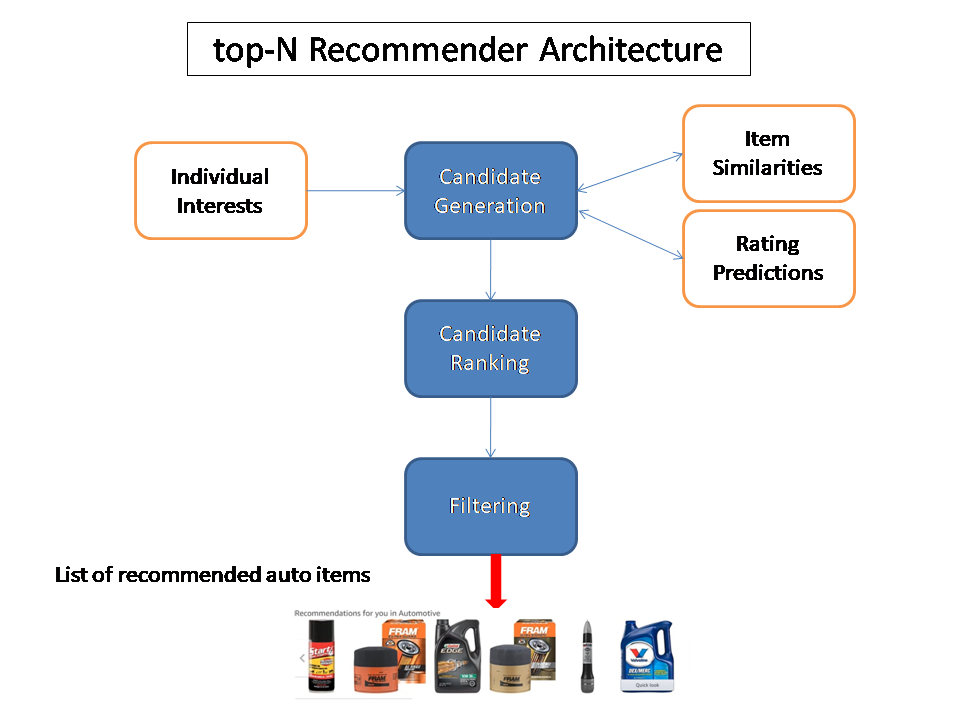

In [ ]:
from IPython.display import Image
Image(filename="/content/top-N Recommender Architecture.png", width=600, height=400)

# Implementation in Google Colab using Python
In this demo, we will use the public available Movielens datasets to train and build the recommendation system. We will use an open source recommender system library, **scikit-surprise version 1.1.1**. Surprise is an excellent Python scikit package for building and analysing recommendatin systems that uses explicit rating data. 

Movielens' datasets consist of movies.csv and rating.csv which are complete without nan or duplicated entries. The model evaluation metrics computed for accuracy are RMSE, MAE, hit rank, coverage, diversity and novelty.

In this implementation, we will use **User-based Collaborative Filtering** technique to build the recommendation engine together with the evaluation result for the model.

The implementation algorithms and steps are as follow:-
1. load datasets and generate topN candidates based on the rating dataset i.e. define the GetTopN() method.
2. Compute HitRate(), Rating HitRate(), AverageReciprocalHitRank(), UserCoverage
3. Compute movie popularity ranks to measure novelty 

4. Compute item similarities using KNN algorithm to measure diversity

5. Build recommendation model with SVD algorithm

6. Compute recommendations

7. Evaluate accuracy of model with RMSE and MAE

8. Evaluate top-10 recommendations

In [ ]:
# setting up Python environment
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 15.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633753 sha256=fcca1618b998e2a1bcb8f7815f7c8e9c0e7b38f1b26a534c9a6029fc16dbfb75
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Each cell below can be implemented as individual .py files and imported as a Py object*

In [ ]:
import os
import csv
import sys
import re

from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import numpy as np

class MovieLens:

    movieID_to_name = {}
    name_to_movieID = {}
    ratingsPath = '/content/drive/MyDrive/WORK MATERIALS/VNLIFE/ml-latest-small/ratings.csv'
    moviesPath = '/content/drive/MyDrive/WORK MATERIALS/VNLIFE/ml-latest-small/movies.csv'
    
    def loadMovieLensLatestSmall(self):

        # Look for files relative to the directory we are running from
        os.chdir(os.path.dirname(sys.argv[0]))

        ratingsDataset = 0
        self.movieID_to_name = {}
        self.name_to_movieID = {}

        reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

        ratingsDataset = Dataset.load_from_file(self.ratingsPath, reader=reader)

        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
                movieReader = csv.reader(csvfile)
                next(movieReader)  #Skip header line
                for row in movieReader:
                    movieID = int(row[0])
                    movieName = row[1]
                    self.movieID_to_name[movieID] = movieName
                    self.name_to_movieID[movieName] = movieID

        return ratingsDataset

    def getUserRatings(self, user):
        userRatings = []
        hitUser = False
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                userID = int(row[0])
                if (user == userID):
                    movieID = int(row[1])
                    rating = float(row[2])
                    userRatings.append((movieID, rating))
                    hitUser = True
                if (hitUser and (user != userID)):
                    break

        return userRatings

    def getPopularityRanks(self):
        ratings = defaultdict(int)
        rankings = defaultdict(int)
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                movieID = int(row[1])
                ratings[movieID] += 1
        rank = 1
        for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[movieID] = rank
            rank += 1
        return rankings
    
    def getGenres(self):
        genres = defaultdict(list)
        genreIDs = {}
        maxGenreID = 0
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)  #Skip header line
            for row in movieReader:
                movieID = int(row[0])
                genreList = row[2].split('|')
                genreIDList = []
                for genre in genreList:
                    if genre in genreIDs:
                        genreID = genreIDs[genre]
                    else:
                        genreID = maxGenreID
                        genreIDs[genre] = genreID
                        maxGenreID += 1
                    genreIDList.append(genreID)
                genres[movieID] = genreIDList
        # Convert integer-encoded genre lists to bitfields that we can treat as vectors
        for (movieID, genreIDList) in genres.items():
            bitfield = [0] * maxGenreID
            for genreID in genreIDList:
                bitfield[genreID] = 1
            genres[movieID] = bitfield            
        
        return genres
    
    def getYears(self):
        p = re.compile(r"(?:\((\d{4})\))?\s*$")
        years = defaultdict(int)
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)
            for row in movieReader:
                movieID = int(row[0])
                title = row[1]
                m = p.search(title)
                year = m.group(1)
                if year:
                    years[movieID] = int(year)
        return years
    
    def getMiseEnScene(self):
        mes = defaultdict(list)
        with open("LLVisualFeatures13K_Log.csv", newline='') as csvfile:
            mesReader = csv.reader(csvfile)
            next(mesReader)
            for row in mesReader:
                movieID = int(row[0])
                avgShotLength = float(row[1])
                meanColorVariance = float(row[2])
                stddevColorVariance = float(row[3])
                meanMotion = float(row[4])
                stddevMotion = float(row[5])
                meanLightingKey = float(row[6])
                numShots = float(row[7])
                mes[movieID] = [avgShotLength, meanColorVariance, stddevColorVariance,
                   meanMotion, stddevMotion, meanLightingKey, numShots]
        return mes
    
    def getMovieName(self, movieID):
        if movieID in self.movieID_to_name:
            return self.movieID_to_name[movieID]
        else:
            return ""
        
    def getMovieID(self, movieName):
        if movieName in self.name_to_movieID:
            return self.name_to_movieID[movieName]
        else:
            return 0

In [ ]:
import itertools

from surprise import accuracy
from collections import defaultdict

class RecommenderMetrics:

    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)

    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)

    def GetTopN(predictions, n=10, minimumRating=4.0):
        topN = defaultdict(list)


        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(movieID), estimatedRating))

        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]

        return topN

    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0

        # For each left-out rating
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutMovieID = leftOut[1]
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == int(movieID)):
                    hit = True
                    break
            if (hit) :
                hits += 1

            total += 1

        # Compute overall precision
        return hits/total

    def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
        hits = 0
        total = 0

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Only look at ability to recommend things the users actually liked...
            if (actualRating >= ratingCutoff):
                # Is it in the predicted top 10 for this user?
                hit = False
                for movieID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutMovieID) == movieID):
                        hit = True
                        break
                if (hit) :
                    hits += 1

                total += 1

        # Compute overall precision
        return hits/total

    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits[actualRating] += 1

            total[actualRating] += 1

        # Compute overall precision
        for rating in sorted(hits.keys()):
            print (rating, hits[rating] / total[rating])

    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hitRank = 0
            rank = 0
            for movieID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutMovieID) == movieID):
                    hitRank = rank
                    break
            if (hitRank > 0) :
                summation += 1.0 / hitRank

            total += 1

        return summation / total

    # What percentage of users have at least one "good" recommendation
    def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for movieID, predictedRating in topNPredicted[userID]:
                if (predictedRating >= ratingThreshold):
                    hit = True
                    break
            if (hit):
                hits += 1

        return hits / numUsers

    def Diversity(topNPredicted, simsAlgo):
        n = 0
        total = 0
        simsMatrix = simsAlgo.compute_similarities()
        for userID in topNPredicted.keys():
            pairs = itertools.combinations(topNPredicted[userID], 2)
            for pair in pairs:
                movie1 = pair[0][0]
                movie2 = pair[1][0]
                innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
                innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
                similarity = simsMatrix[innerID1][innerID2]
                total += similarity
                n += 1

        S = total / n
        return (1-S)

    def Novelty(topNPredicted, rankings):
        n = 0
        total = 0
        for userID in topNPredicted.keys():
            for rating in topNPredicted[userID]:
                movieID = rating[0]
                rank = rankings[movieID]
                total += rank
                n += 1
        return total / n


In [ ]:
#from RecommenderMetrics import RecommenderMetrics
#from EvaluationData import EvaluationData

class EvaluatedAlgorithm:
    
    def __init__(self, algorithm, name):
        self.algorithm = algorithm
        self.name = name
        
    def Evaluate(self, evaluationData, doTopN, n=10, verbose=True):
        metrics = {}
        # Compute accuracy
        if (verbose):
            print("Evaluating accuracy...")
        self.algorithm.fit(evaluationData.GetTrainSet())
        predictions = self.algorithm.test(evaluationData.GetTestSet())
        metrics["RMSE"] = RecommenderMetrics.RMSE(predictions)
        metrics["MAE"] = RecommenderMetrics.MAE(predictions)
        
        if (doTopN):
            # Evaluate top-10 with Leave One Out testing
            if (verbose):
                print("Evaluating top-N with leave-one-out...")
            self.algorithm.fit(evaluationData.GetLOOCVTrainSet())
            leftOutPredictions = self.algorithm.test(evaluationData.GetLOOCVTestSet())        
            # Build predictions for all ratings not in the training set
            allPredictions = self.algorithm.test(evaluationData.GetLOOCVAntiTestSet())
            # Compute top 10 recs for each user
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Computing hit-rate and rank metrics...")
            # See how often we recommended a movie the user actually rated
            metrics["HR"] = RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)   
            # See how often we recommended a movie the user actually liked
            metrics["cHR"] = RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions)
            # Compute ARHR
            metrics["ARHR"] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions)
        
            #Evaluate properties of recommendations on full training set
            if (verbose):
                print("Computing recommendations with full data set...")
            self.algorithm.fit(evaluationData.GetFullTrainSet())
            allPredictions = self.algorithm.test(evaluationData.GetFullAntiTestSet())
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Analyzing coverage, diversity, and novelty...")
            # Print user coverage with a minimum predicted rating of 4.0:
            metrics["Coverage"] = RecommenderMetrics.UserCoverage(  topNPredicted, 
                                                                   evaluationData.GetFullTrainSet().n_users, 
                                                                   ratingThreshold=4.0)
            # Measure diversity of recommendations:
            metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, evaluationData.GetSimilarities())
            
            # Measure novelty (average popularity rank of recommendations):
            metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted, 
                                                            evaluationData.GetPopularityRankings())
        
        if (verbose):
            print("Analysis complete.")
    
        return metrics
    
    def GetName(self):
        return self.name
    
    def GetAlgorithm(self):
        return self.algorithm

In [ ]:
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline

class EvaluationData:
    
    def __init__(self, data, popularityRankings):
        
        self.rankings = popularityRankings
        
        #Build a full training set for evaluating overall properties
        self.fullTrainSet = data.build_full_trainset()
        self.fullAntiTestSet = self.fullTrainSet.build_anti_testset()
        
        #Build a 75/25 train/test split for measuring accuracy
        self.trainSet, self.testSet = train_test_split(data, test_size=.25, random_state=1)
        
        #Build a "leave one out" train/test split for evaluating top-N recommenders
        #And build an anti-test-set for building predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test
            
        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()
        
        #Compute similarty matrix between items so we can measure diversity
        sim_options = {'name': 'cosine', 'user_based': False}
        self.simsAlgo = KNNBaseline(sim_options=sim_options)
        self.simsAlgo.fit(self.fullTrainSet)
            
    def GetFullTrainSet(self):
        return self.fullTrainSet
    
    def GetFullAntiTestSet(self):
        return self.fullAntiTestSet
    
    def GetAntiTestSetForUser(self, testSubject):
        trainset = self.fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset

    def GetTrainSet(self):
        return self.trainSet
    
    def GetTestSet(self):
        return self.testSet
    
    def GetLOOCVTrainSet(self):
        return self.LOOCVTrain
    
    def GetLOOCVTestSet(self):
        return self.LOOCVTest
    
    def GetLOOCVAntiTestSet(self):
        return self.LOOCVAntiTestSet
    
    def GetSimilarities(self):
        return self.simsAlgo
    
    def GetPopularityRankings(self):
        return self.rankings

In [14]:
#from EvaluationData import EvaluationData
#from EvaluatedAlgorithm import EvaluatedAlgorithm

class Evaluator:
    
    algorithms = []
    
    def __init__(self, dataset, rankings):
        ed = EvaluationData(dataset, rankings)
        self.dataset = ed
        
    def AddAlgorithm(self, algorithm, name):
        alg = EvaluatedAlgorithm(algorithm, name)
        self.algorithms.append(alg)
        
    def Evaluate(self, doTopN):
        results = {}
        for algorithm in self.algorithms:
            print("Evaluating ", algorithm.GetName(), "...")
            results[algorithm.GetName()] = algorithm.Evaluate(self.dataset, doTopN)

        # Print results
        print("\n")
        
        if (doTopN):
            print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                    "Algorithm", "RMSE", "MAE", "HR", "cHR", "ARHR", "Coverage", "Diversity", "Novelty"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
                        name, metrics["RMSE"], metrics["MAE"], metrics["HR"], metrics["cHR"], metrics["ARHR"],
                                      metrics["Coverage"], metrics["Diversity"], metrics["Novelty"]))
        else:
            print("{:<10} {:<10} {:<10}".format("Algorithm", "RMSE", "MAE"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f}".format(name, metrics["RMSE"], metrics["MAE"]))
        print('no more legend **************')        
        
        
    def SampleTopNRecs(self, ml, testSubject=85, k=10):
        
        for algo in self.algorithms:
            print("\nUsing recommender ", algo.GetName())
            
            print("\nBuilding recommendation model...")
            trainSet = self.dataset.GetFullTrainSet()
            algo.GetAlgorithm().fit(trainSet)
            
            print("Computing recommendations...")
            testSet = self.dataset.GetAntiTestSetForUser(testSubject)
        
            predictions = algo.GetAlgorithm().test(testSet)
            
            recommendations = []
            
            print ("\nWe recommend:")
            for userID, movieID, actualRating, estimatedRating, _ in predictions:
                intMovieID = int(movieID)
                recommendations.append((intMovieID, estimatedRating))
            
            recommendations.sort(key=lambda x: x[1], reverse=True)
            
            for ratings in recommendations[:10]:
                print(ml.getMovieName(ratings[0]), ratings[1])

## Test Script

In [16]:
#from MovieLens import MovieLens
#from Evaluator import Evaluator
from surprise import SVD
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(0)
random.seed(0)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to evaluate them
evaluator = Evaluator(evaluationData, rankings)

# Add an SVD recommender
SVDAlgorithm = SVD(random_state=10)
evaluator.AddAlgorithm(SVDAlgorithm, "SVD")

# Add a random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

# 
evaluator.Evaluate(True)
#
evaluator.SampleTopNRecs(ml)

Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  SVD ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.
Evaluating  Random ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.
Evaluating  SVD ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with full data set...
Analyzi

# Summary
From the model result, we can see that SVD has better accuracy scores than random. SVD is better at hit rates as well. Coverage is almost 100%. Diversity is lower in SVD than random as expected as people tend to have consistent interests, good recommendations for specific user would be more similar to each other than users polled at random which is not personalised in any way. Novelty for SVD is lower than random as SVD will give good recommendations from discovered popular movies instead of pulling all sorts of movies randomly from the long tail.

To further improve the model, we can employ hybrid content and collaborative filtering techniques and also ensemble technique or more advanced recommenders like deep learning like convolutional neural network which has been shown to outperform SVD or KNN algorithm.   